# Assignment 2 For Clustering: Sessa Empirical Estimator

Basilisco, Farah Jane & Bonachita, Clybel Djen

---

## Instructions

1. Read the Journals about the Sessa Empirical Estimator.
2. Convert the R codes into Python Codes (use jupyter notebook).
3. Using Simulated data (https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full) or a real world datasets of your choice (You can obtain it in Kaggle or in https://archive.ics.uci.edu/), perform the Sessa Empircal Estimator and generate some insights.
4. The Sessa Empirical Estimator uses K-Means clustering (again recall the disadvantages of K-Means), try to substitute a different clustering algorithm, generate a new insight using the new clustering algorithm.
5. Compare your results between Sessa Empirical Estimator using K-Means, and Sessa Empirical Estimator using the clustering algorithm of your choice.

## What is SEE?

The Sessa Empirical Estimator (SEE) is a data-driven algorithm designed to estimate the duration of filled prescriptions when exact prescription duration is unknown. It relies on analyzing temporal distances between consecutive prescription refills to infer medication adherence patterns. The process begins by computing the Empirical Cumulative Distribution Function (ECDF) of the time gaps between refills. To remove extreme values caused by irregular users, only the first 80% of the ECDF is retained. After filtering, SEE applies clustering techniques to group similar prescription refill patterns. The estimator assigns a duration to each patient's prescriptions based on the median duration within their respective cluster.

## K-Means vs DBSCAN
SEE traditionally uses K-Means for clustering because it efficiently groups patients with similar prescription refill intervals, reducing intra-cluster variability. However, K-Means has limitations in this context. It assumes that clusters are spherical and evenly distributed, which is often not the case for real-world prescription refill data. Additionally, K-Means is highly sensitive to outliers, which can distort cluster assignments when patients have irregular refill behaviors. Another drawback is that it requires defining the number of clusters in advance, which may not always be optimal for the dataset.

To address these limitations, __we replaced K-Means with DBSCAN__ (Density-Based Spatial Clustering of Applications with Noise) as an alternative clustering method. DBSCAN does not require predefining the number of clusters, making it more flexible for datasets with unknown patterns. Unlike K-Means, which forces every data point into a cluster, DBSCAN can detect and classify outliers as noise, preventing them from skewing the clustering results. This makes it particularly useful for SEE, where some patients exhibit irregular refill behavior that should not be forced into an existing cluster. Furthermore, DBSCAN can identify clusters of arbitrary shapes, whereas K-Means assumes that clusters are convex and evenly distributed. Given the nature of medication refill data, where gaps between refills may vary widely, DBSCAN provides a more robust and accurate clustering approach for the Sessa Empirical Estimator.

## Python Implementation

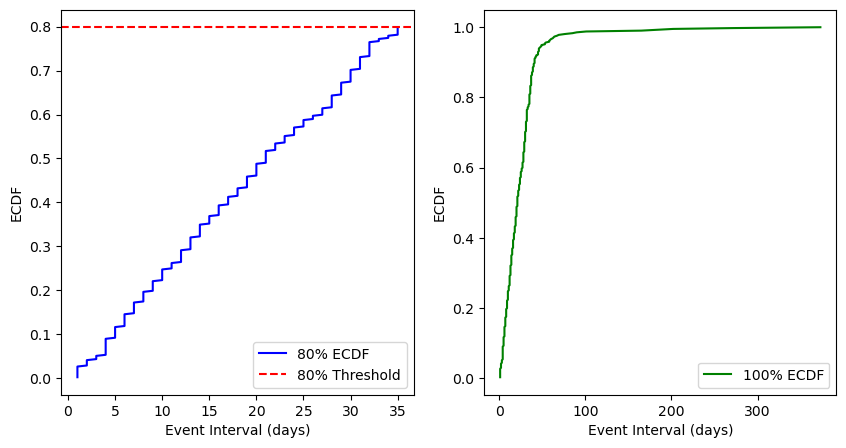

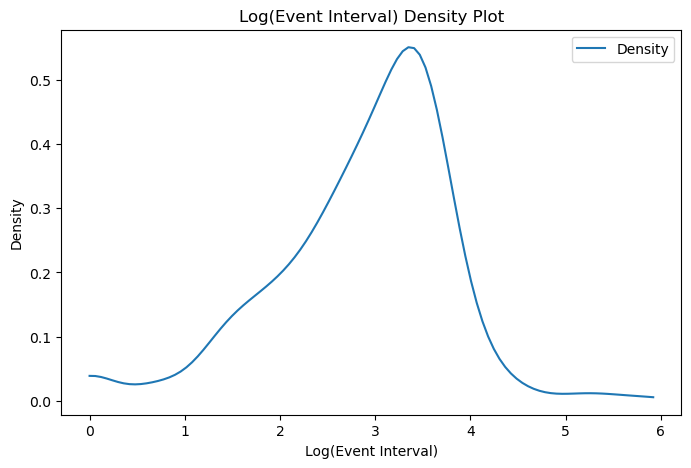

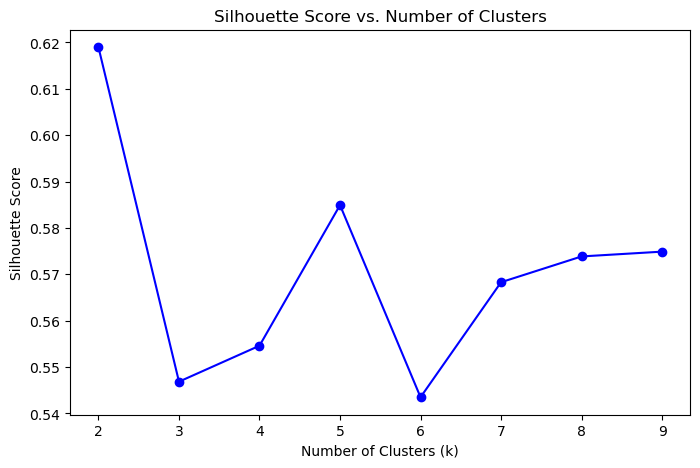

/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


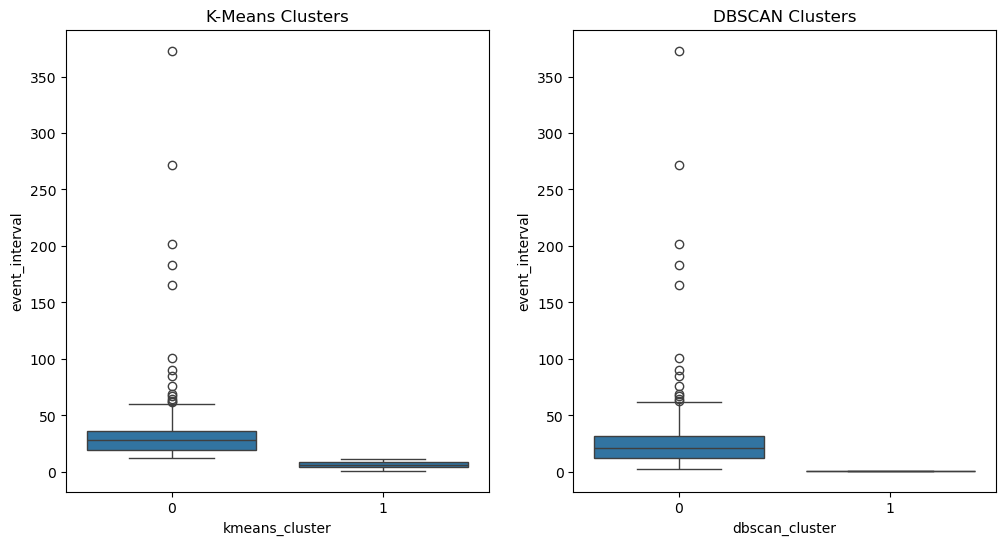

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import warnings
warnings.simplefilter("always")

def load_data(file_path):
    data = pd.read_csv(file_path)
    data.rename(columns={'DATE': 'eksd', 'PATIENT_ID': 'pnr'}, inplace=True)
    return data

def preprocess_data(data):
    data['eksd'] = pd.to_datetime(data['eksd'])
    data = data.sort_values(by=['pnr', 'eksd'])
    data['prev_eksd'] = data.groupby('pnr')['eksd'].shift(1)
    data = data.dropna()
    data['event_interval'] = (data['eksd'] - data['prev_eksd']).dt.days
    return data[data['event_interval'] > 0]

def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

def plot_ecdf(data):
    x, y = ecdf(data['event_interval'])
    df_ecdf = pd.DataFrame({'x': x, 'y': y})
    df_ecdf = df_ecdf[df_ecdf['y'] <= 0.8]
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(df_ecdf['x'], df_ecdf['y'], label='80% ECDF', color='blue')
    plt.axhline(y=0.8, linestyle='dashed', color='red', label='80% Threshold')
    plt.xlabel("Event Interval (days)")
    plt.ylabel("ECDF")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, y, label='100% ECDF', color='green')
    plt.xlabel("Event Interval (days)")
    plt.ylabel("ECDF")
    plt.legend()
    plt.show()

def plot_density(data):
    density = gaussian_kde(np.log(data['event_interval']))
    x_vals = np.linspace(min(np.log(data['event_interval'])), max(np.log(data['event_interval'])), 100)
    y_vals = density(x_vals)
    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, y_vals, label="Density")
    plt.title("Log(Event Interval) Density Plot")
    plt.xlabel("Log(Event Interval)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

def kmeans_clustering(data):
    scaled_data = np.log(data[['event_interval']])
    sil_scores = {}
    for k in range(2, 10):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(scaled_data)
        score = silhouette_score(scaled_data, kmeans.labels_)
        sil_scores[k] = score
    plot_silhouette_scores(sil_scores)
    optimal_k = max(sil_scores, key=sil_scores.get)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit(scaled_data)
    data['kmeans_cluster'] = kmeans.labels_
    return data

def plot_silhouette_scores(sil_scores):
    plt.figure(figsize=(8, 5))
    plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score vs. Number of Clusters")
    plt.show()

def dbscan_clustering(data):
    scaled_data = np.log(data[['event_interval']])
    neighbors = NearestNeighbors(n_neighbors=5)
    neighbors_fit = neighbors.fit(scaled_data)
    distances, indices = neighbors_fit.kneighbors(scaled_data)
    distances = np.sort(distances[:, -1])
    eps_value = 0.5  
    dbscan = DBSCAN(eps=eps_value, min_samples=5)
    data['dbscan_cluster'] = dbscan.fit_predict(scaled_data)
    return data

def plot_clusters(data):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(x=data['kmeans_cluster'], y=data['event_interval'], orientation='vertical')
    plt.title("K-Means Clusters")
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data['dbscan_cluster'], y=data['event_interval'], orientation='vertical')
    plt.title("DBSCAN Clusters")
    plt.show()

def main():
    file_path = 'med_events.csv'
    data = load_data(file_path)
    data = preprocess_data(data)
    plot_ecdf(data)
    plot_density(data)
    data = kmeans_clustering(data)
    data = dbscan_clustering(data)
    plot_clusters(data)

if __name__ == "__main__":
    main()


## Conclusion
Unlike K-Means, which forces every data point into a cluster regardless of its relevance, DBSCAN is capable of identifying meaningful groupings while filtering out outliers that do not conform to the general trend. This is particularly beneficial in the context of the Sessa Empirical Estimator, where prescription refill behaviors can be highly variable, and rigid clustering approaches may lead to misleading classifications. Therefore, __DBSCAN provides better results because it can detect clusters of patients with similar refill patterns while excluding noisy, irregular prescriptions.__